# Preprocessing (optional)
## Generating Metadata

Here we are going to collect information about the CFGs and CDFGs of the applications and build a metadata database (at './data/ccpe-applications-information.yaml')to easily construct the inputs to GNN.
This information includes:
- Name of the applications
- Location of the file for an application and it respective optimization sequence
- Number of nodes in the graph representation of CFG and CDFG for each application
- The execution time for each application with each optimization sequence

This part is optional and must be run only once to create a metadata file.

In [1]:
import gc
import os
import sys
import yaml
import glob
import numpy as np
import pickle
import tensorflow as tf
import random
import tqdm

from collections import defaultdict

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from spektral.datasets import delaunay
from spektral.layers import *
from spektral.utils.convolution import localpooling_filter
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tqdm.contrib.concurrent import process_map, thread_map

from utils import yaml_load, get_section

%matplotlib inline

First, lets list all CFG and CDFG files and discover how many nodes each graph has

In [2]:
# Utility functions

# Get the number of nodes for each application in CFG representation
def get_number_of_cfg_nodes(filename):
    # Get lines for node section
    yaml_nodes_section = get_section(filename, 'nodes_features:')
    # Get the highest node number and return
    return (filename, max([int(node.split(':')[0]) for node in yaml_nodes_section])+1)

# Get the number of nodes for each application in CDFG representation
def get_number_of_cdfg_nodes(filename):
    # Get lines for nodes_features section
    yaml_node_features_section = get_section(filename, 'nodes_features:')
    # Get the highest node number and return
    return (filename, max([int(node.split(':')[0]) for node in yaml_node_features_section])+1)

In [3]:
# Listing all CFG Files
cfg_directory = './data/ccpe-dados/cfg.llvm'
cfg_files = glob.glob(f'{cfg_directory}/**/*.yaml', recursive=True)
print(f"Found {len(cfg_files)} files in {cfg_directory}")

# Listing all CDFG Files
cdfg_directory = './data/ccpe-dados/cdfg.programl'
cdfg_files = glob.glob(f'{cdfg_directory}/**/*.yaml', recursive=True)
print(f"Found {len(cdfg_files)} files in {cdfg_directory}")

# Listing all runtime files
runtime_directory = './data/runtime'
runtime_files = glob.glob(f'{runtime_directory}/**/*.yaml', recursive=True)
print(f"Found {len(runtime_files)} files in {runtime_directory}")

# Get the number of nodes for all CFG graphs
cfg_number_of_nodes = thread_map(get_number_of_cfg_nodes, cfg_files, desc='CFG Files processed')
cfg_number_of_nodes = dict(cfg_number_of_nodes)
print(f"Number of CFG graphs: {len(cfg_number_of_nodes)}")

# Get the number of nodes for all CDFG graphs
cdfg_number_of_nodes = thread_map(get_number_of_cdfg_nodes, cdfg_files, desc='CDFG Files processed')
cdfg_number_of_nodes = dict(cdfg_number_of_nodes)
print(f"Number of CDFG graphs: {len(cdfg_number_of_nodes)}")

Found 29990 files in ./data/ccpe-dados/cfg.llvm
Found 29984 files in ./data/ccpe-dados/cdfg.programl
Found 302 files in ./data/runtime


CFG Files processed:   0%|          | 0/29990 [00:00<?, ?it/s]

Number of CFG graphs: 29990


CDFG Files processed:   0%|          | 0/29984 [00:00<?, ?it/s]

Number of CDFG graphs: 29984


CFG Graphs. Statistics from 29990 applications:
    Min value: 3
    Max value: 26796
    Average: 808.2788929643215
    Stdev: 2585.113628076723
    Mean: 808.2788929643215
    25th percentile: 49.0
    Median: 109.0
    75th percentile: 472.0
    95th percentile: 3815.0999999999985


(array([2.7096e+04, 1.0890e+03, 3.5300e+02, 2.7100e+02, 3.9800e+02,
        1.8000e+02, 4.6000e+01, 3.7000e+01, 4.1000e+01, 2.0000e+01,
        4.0000e+01, 4.8000e+01, 1.1100e+02, 7.3000e+01, 3.9000e+01,
        4.8000e+01, 4.1000e+01, 3.8000e+01, 1.5000e+01, 6.0000e+00]),
 array([3.000000e+00, 1.342650e+03, 2.682300e+03, 4.021950e+03,
        5.361600e+03, 6.701250e+03, 8.040900e+03, 9.380550e+03,
        1.072020e+04, 1.205985e+04, 1.339950e+04, 1.473915e+04,
        1.607880e+04, 1.741845e+04, 1.875810e+04, 2.009775e+04,
        2.143740e+04, 2.277705e+04, 2.411670e+04, 2.545635e+04,
        2.679600e+04]),
 <BarContainer object of 20 artists>)

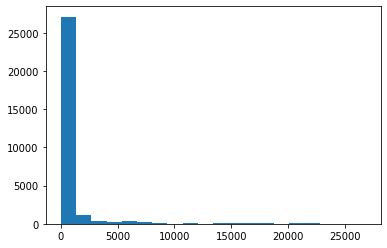

In [4]:
values = [int(v) for v in cfg_number_of_nodes.values()]
print(f"""CFG Graphs. Statistics from {len(values)} applications:
    Min value: {min(values)}
    Max value: {max(values)}
    Average: {np.average(values)}
    Stdev: {np.std(values)}
    Mean: {np.mean(values)}
    25th percentile: {np.percentile(values, 25)}
    Median: {np.median(values)}
    75th percentile: {np.percentile(values, 75)}
    95th percentile: {np.percentile(values, 95)}""")

plt.hist(values, 20)

CDFG Graphs. Statistics from 29984 applications:
    Min value: 38
    Max value: 472890
    Average: 10924.06423425827
    Stdev: 35517.21571679414
    Mean: 10924.06423425827
    25th percentile: 616.0
    Median: 1504.5
    75th percentile: 4881.25
    95th percentile: 58074.69999999997


(array([2.7535e+04, 9.0300e+02, 2.3400e+02, 5.2600e+02, 1.6200e+02,
        7.4000e+01, 9.3000e+01, 1.2100e+02, 7.7000e+01, 3.0000e+01,
        5.8000e+01, 5.2000e+01, 2.1000e+01, 3.8000e+01, 2.1000e+01,
        1.5000e+01, 6.0000e+00, 1.1000e+01, 4.0000e+00, 3.0000e+00]),
 array([3.800000e+01, 2.368060e+04, 4.732320e+04, 7.096580e+04,
        9.460840e+04, 1.182510e+05, 1.418936e+05, 1.655362e+05,
        1.891788e+05, 2.128214e+05, 2.364640e+05, 2.601066e+05,
        2.837492e+05, 3.073918e+05, 3.310344e+05, 3.546770e+05,
        3.783196e+05, 4.019622e+05, 4.256048e+05, 4.492474e+05,
        4.728900e+05]),
 <BarContainer object of 20 artists>)

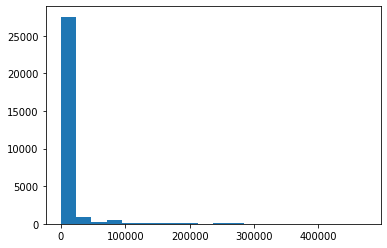

In [5]:
values = [int(v) for v in cdfg_number_of_nodes.values()]
print(f"""CDFG Graphs. Statistics from {len(values)} applications:
    Min value: {min(values)}
    Max value: {max(values)}
    Average: {np.average(values)}
    Stdev: {np.std(values)}
    Mean: {np.mean(values)}
    25th percentile: {np.percentile(values, 25)}
    Median: {np.median(values)}
    75th percentile: {np.percentile(values, 75)}
    95th percentile: {np.percentile(values, 95)}""")

plt.hist(values, 20)

Now we are going to group all CFGs and CFGs files by its applications and optimization sequences
We going to have a dictionary, like this example:

{

    application_1: {

        sequence_0: {

            cfg_file: '/path/to/cfg/file'

            number_cfg_nodes: 10

            cdfg_file: '/path/to/cdfg/file'

            number_cdfg_nodes: 20

            exectime: 1.234

        }

        sequence_1: {
            
            cfg_file: '/path/to/cfg/file'

            number_cfg_nodes: 15

            cdfg_file: '/path/to/cdfg/file'

            number_cdfg_nodes: 22

            exectime: 0.987

        }

    }

    application_2: {...}
    
 }

This information is used to generate inputs to GNN and is saved to './data/ccpe-applications-information.yaml'

In [6]:
def get_representation(filename: str) -> dict:
    representation = defaultdict(dict)
    # Extract the application name, without path and extensions
    app_name = os.path.basename(filename)
    app_name = app_name.split('.rnd.yaml')[0]
    
    # Lets group all CFG and CDFG files with same prefix (i.e., CFGs and CDFGs for the same application)
    cfgs_with_prefix = [fname for fname in cfg_files if os.path.basename(fname).startswith(app_name)]
    cdfgs_with_prefix = [fname for fname in cdfg_files if os.path.basename(fname).startswith(app_name)]

    # Get the rutime information for the application. It includes the execution time for the application
    # compiled with different optimization sequences
    with open(filename, 'rt') as f:
        app_runtime_info = yaml.safe_load(f)

    # Group CFGs and CDFGs filenames by their optimization sequences 
    # E.g.: CFGs={0: file1, 1: file2, ..., 99: file99}
    cfgs_with_prefix = {int(os.path.basename(fname).split('.ll.')[0].split('.')[-1]): fname for fname in cfgs_with_prefix}
    cdfgs_with_prefix = {int(os.path.basename(fname).split('.progaml.')[0].split('.')[-1]): fname for fname in cdfgs_with_prefix}

    # Finally, let's group applications with sequence levels and runtime info
    # E.g: representation_files = {app1: {0: (CFG_FILE, CDFG_FILE, EXECTIME), 1: (CFG_FILE, CDFG_FILE, EXECTIME), ..., }, app2: {...} }
    for sequence_no, values in app_runtime_info.items():
        if sequence_no not in cfgs_with_prefix:
            print(f"CFG from application {app_name} with optimization sequence {sequence_no} does not exists. Skipping..")
            continue
        if sequence_no not in cdfgs_with_prefix:
            print(f"CDFG from application {app_name} with optimization sequence {sequence_no} does not exists. Skipping..")
            continue
        representation[app_name][sequence_no] = {
            'cfg_file': cfgs_with_prefix[sequence_no], 
            'number_cfg_nodes': cfg_number_of_nodes[cfgs_with_prefix[sequence_no]],
            'cdfg_file': cdfgs_with_prefix[sequence_no],
            'number_cdfg_nodes': cdfg_number_of_nodes[cdfgs_with_prefix[sequence_no]],
            'exectime': app_runtime_info[sequence_no]['f'],
            'runtime_file': filename
        }
    
    return representation

# Iterate over each runtime file (applications that effectively executed)
representation_files = thread_map(get_representation, runtime_files, desc="Applications processed")
# Merge all dicts to a single dict
representation_files = {k: v for d in representation_files for k, v in d.items()}

print(f'Processed {len(representation_files)} applications...')

Applications processed:   0%|          | 0/302 [00:00<?, ?it/s]

g..
CFG from application MiBench.automotive-qsort.0 with optimization sequence 22 does not exists. Skipping..
CFG from application MiBench.automotive-qsort.0 with optimization sequence 23 does not exists. Skipping..
CFG from application MiBench.automotive-qsort.0 with optimization sequence 24 does not exists. Skipping..
CFG from application MiBench.automotive-qsort.0 with optimization sequence 25 does not exists. Skipping..
CFG from application MiBench.automotive-qsort.0 with optimization sequence 26 does not exists. Skipping..
CFG from application MiBench.automotive-qsort.0 with optimization sequence 27 does not exists. Skipping..
CFG from application MiBench.automotive-qsort.0 with optimization sequence 28 does not exists. Skipping..
CFG from application MiBench.automotive-qsort.0 with optimization sequence 29 does not exists. Skipping..
CFG from application MiBench.automotive-qsort.0 with optimization sequence 30 does not exists. Skipping..
CFG from application MiBench.automotive-qs

In [8]:
# The output file to store processed information
output_metadata_file = './data/ccpe-applications-information.yaml'

with open(output_metadata_file, 'wt') as f:
    yaml.dump(representation_files, f)
    print(f"Metadata information from {len(representation_files)} applications were successfully saved to {output_file}")

Metadata information from 299 applications were successfully saved to ./data/ccpe-applications-information.yaml
